In [3]:
from typing import Tuple
import numpy as np
import tifffile as tif

from pathlib import Path
import json
import os
from natsort import natsorted

def read_json_as_dict(filepath: str) -> dict:
    """
    Reads a json as dictionary.
    Parameters
    ------------------------
    filepath: PathLike
        Path where the json is located.
    Returns
    ------------------------
    dict:
        Dictionary with the data the json has.
    """

    dictionary = {}

    if os.path.exists(filepath):
        try:
            with open(filepath) as json_file:
                dictionary = json.load(json_file)

        except UnicodeDecodeError:
            print("Error reading json with utf-8, trying different approach")
            # This might lose data, verify with Jeff the json encoding
            with open(filepath, "rb") as json_file:
                data = json_file.read()
                data_str = data.decode("utf-8", errors="ignore")
                dictionary = json.loads(data_str)

    #             print(f"Reading {filepath} forced: {dictionary}")

    return dictionary

def get_microscope_flats(
    channel_name: str, derivatives_folder: str
) -> Tuple[np.ndarray]:
    """
    Gets the microscope flats

    Parameters
    ----------
    channel_name : str
        Channel to be processed.

    derivatives_folder: str
        Path where the derivatives folder is.

    logger: logging.Logger
        Logging object

    Raises
    ------
    KeyError:
        Raises whenever we can't find the XY folders
        or brain side.

    Returns
    -------
    Tuple[List[ArrayLike], dictionary]
        Tuple with the flafields per brain hemisphere,
        current dark from the microscope and metadata.json
        content.
    """
    flatfield = None
    metadata_json = None

    waves = [p for p in channel_name.split("_") if p.isdigit()]

    metadata_json_path = derivatives_folder.joinpath("metadata.json")

    if metadata_json_path.exists() and len(waves):
        # If the flats exist, I can't apply the flats
        # without the metadata.json since I do not know which
        # brain hemisphere is correct for each flat

        orig_metadata_json = read_json_as_dict(filepath=metadata_json_path)
        curr_emision_wave = int(waves[0])
        tile_config = orig_metadata_json.get("tile_config")
        metadata_json = {}

        if tile_config is None:
            raise ValueError("Please, verify metadata.json")

        # Getting only XY folders for the current emission wave
        # to know which locations used which flatfield
        for time_step, value in tile_config.items():
            config_em_wave = value.get("Laser")

            if int(config_em_wave) == curr_emision_wave:
                x_folder = value.get("X")
                y_folder = value.get("Y")
                brain_side = value.get("Side")  # 0 left hemisphere, 1 right hemisphere

                if x_folder is None or y_folder is None or brain_side is None:
                    raise KeyError("Please, check the data in metadata.json")

                if metadata_json.get(x_folder) is None:
                    metadata_json[x_folder] = {}

                metadata_json[x_folder][y_folder] = int(brain_side)

        # The flats are one per hemisphere, we need to check
        # metadata.json to know which tile is in which laser
        flatfield = [
            tif.imread(g)
            for g in natsorted(
                list(derivatives_folder.glob(f"FlatReal{curr_emision_wave}_*.tif"))
            )
            if os.path.exists(g)
        ]

        # reading flatfields, we should have 2, one per brain hemisphere
        if len(flatfield) != 2:
            raise ValueError(
                f"Error while reading the microscope flatfields: {flatfield}"
            )

    return flatfield, metadata_json

In [4]:
derivatives_folder = Path("/data/SmartSPIM_717381_2024-07-03_10-49-01/derivatives")

flatfields_488, metadata_json = get_microscope_flats(
    channel_name="Ex_488_Em_525", derivatives_folder=derivatives_folder
)

flatfields_561, metadata_json = get_microscope_flats(
    channel_name="Ex_561_Em_600", derivatives_folder=derivatives_folder
)

flatfields_639, metadata_json = get_microscope_flats(
    channel_name="Ex_639_Em_680", derivatives_folder=derivatives_folder
)

for flatfield in flatfields_488:
    print(flatfield.shape)

Error reading json with utf-8, trying different approach
Error reading json with utf-8, trying different approach
Error reading json with utf-8, trying different approach
(1600, 2000)
(1600, 2000)


In [5]:
from typing import List, Optional

def normalize_image(images: List[np.array]) -> np.ndarray:
    """
    Normalizes the images in a range between
    1.0 and 2.0

    Parameters
    ----------
    images: List[np.array]
        Images to normalize

    Returns
    -------
    np.ndarray
        Normalized image(s)
    """

    images = np.array(images)
    min_val = np.min(images)
    max_val = np.max(images)
    imgs_minus_min = images - min_val
    max_min = max_val - min_val
    normalized_imgs = 1 + np.divide(imgs_minus_min, max_min).astype(np.float16)

    return normalized_imgs

def invert_image(image: np.array) -> np.ndarray:
    """
    Inverts image signal

    Parameters
    ----------
    image: np.array
        Image data to invert

    Returns
    -------
    np.ndarray
        Inverted image
    """

    image = np.array(image)
    inv_image = image.max() - image
    return inv_image

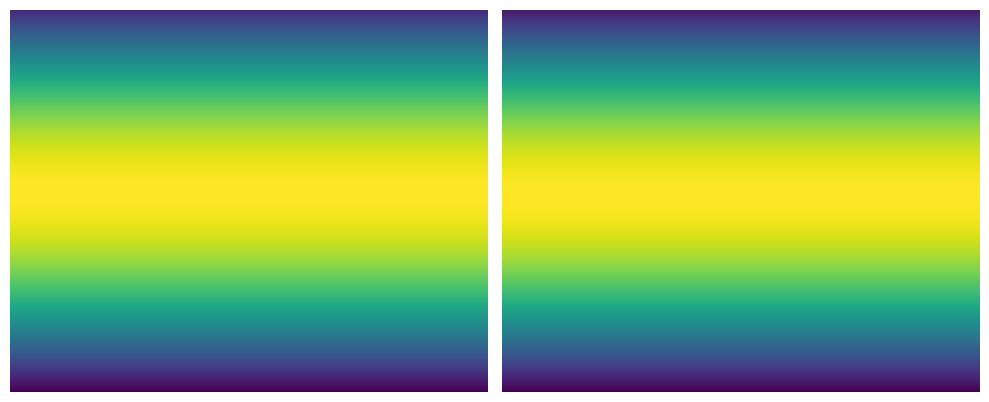

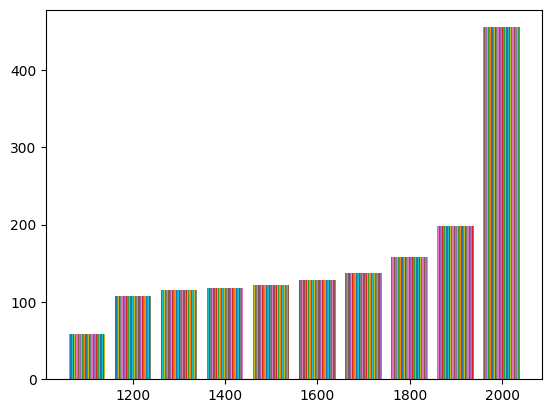

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Display images
# plt.suptitle("flatfield")
ax1.imshow(flatfields_488[0])
ax1.axis('off')  # Turn off axis labels
ax2.imshow(flatfields_488[1])
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

plt.hist(flatfields_488[0])
plt.show()

In [7]:
def flatfield_correction(
    image_tiles: List[np.array],
    flatfield: np.array,
    darkfield: np.array,
    baseline: Optional[np.array] = None,
) -> np.array:
    """
    Corrects smartspim shadows in the tiles generated
    at the SmartSPIM light-sheet microscope.

    Parameters
    ----------
    image_tiles: List[np.array]
        Image tiles that will be corrected

    flatfield: np.array
        Estimated flatfield

    darkfield: np.array
        Estimated darkfield

    baseline: np.array
        Estimated baseline.
        Default: None

    Returns
    -------
    np.array
        Corrected tiles
    """

    image_tiles = np.array(image_tiles)

    if image_tiles.ndim != flatfield.ndim:
        flatfield = np.expand_dims(flatfield, axis=0)

    if image_tiles.ndim != darkfield.ndim:
        darkfield = np.expand_dims(darkfield, axis=0)

    darkfield = darkfield[: image_tiles.shape[-2], : image_tiles.shape[-1]]

    if darkfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the darkfield. Image shape: {image_tiles.shape} - Darkfield shape: {darkfield.shape}"
        )

    if flatfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the flatfield. Image shape: {image_tiles.shape} - Flatfield shape: {flatfield.shape}"
        )

    if baseline is None:
        baseline = np.zeros((image_tiles.shape[0],))

    baseline_indxs = tuple([slice(None)] + ([np.newaxis] * (image_tiles.ndim - 1)))

    # Subtracting dark field
    negative_darkfield = np.where(image_tiles <= darkfield)
    positive_darkfield = np.where(image_tiles > darkfield)

    # subtracting darkfield
    image_tiles[negative_darkfield] = 0
    image_tiles[positive_darkfield] = (
        image_tiles[positive_darkfield] - darkfield[positive_darkfield]
    )

    # Applying flatfield
    corrected_tiles = image_tiles / flatfield - baseline[baseline_indxs]

    # Converting back to uint16
    corrected_tiles = np.clip(corrected_tiles, 0, 65535).astype("uint16")

    return corrected_tiles

In [8]:
# import dask.array as da

# DATASET_PATH = "/data/smartspim_zarr_test/Ex_488_Em_525/429940_372540.zarr/0"
# lazy_data = da.from_zarr(DATASET_PATH)[0, 0, ...]
# tile = lazy_data[2000, ...].compute()
# lazy_data

In [10]:
import imageio.v2 as iio
tile = iio.imread("/data/SmartSPIM_717381_2024-07-03_10-49-01/SmartSPIM/Ex_488_Em_525/494310/494310_367980/040500.png")

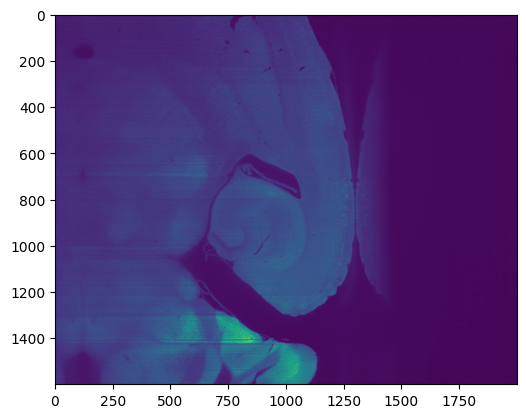

In [11]:
plt.imshow(tile)
plt.show()

In [13]:
darkfield = np.full(tile.shape, 200).astype(np.uint8)

In [ ]:

# Normalizing and inverting flatfields from the microscope
flatfield_test_488 = normalize_image(flatfields_488)
# flatfield_test_488 = invert_image(flatfield_test_488)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Display images
# plt.suptitle("flatfield")
ax1.imshow(flatfields_488[0])
ax1.axis('off')  # Turn off axis labels
ax2.imshow(flatfield_test_488[0])
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

check = flatfields_488[0]#[352:2304-352, 152:2304-152]
check = flatfield_test_488[0]#[352:2304-352, 152:2304-152]

corrected_image = flatfield_correction(
    image_tiles=tile,
    flatfield=check,
    darkfield=darkfield,
    baseline=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin, vmax = np.percentile(tile, (10, 97))
# Display images
# plt.suptitle("flatfield")
ax1.imshow(tile, vmin=vmin, vmax=vmax)
ax1.axis('off')  # Turn off axis labels

vmin, vmax = np.percentile(corrected_image, (10, 97))
ax2.imshow(corrected_image, vmin=vmin, vmax=vmax)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

In [15]:
flat_test = flatfields_488[0]#[352:2304-352, 152:2304-152]

main_image_normalized = tile / np.mean(tile)
flatfield_normalized = flat_test / np.mean(flat_test)

# Perform flatfield correction
corrected_image = main_image_normalized / flatfield_normalized

# Clip values to ensure they are within valid range (0 to 255 for uint8 images)
corrected_image_2 = np.clip(corrected_image, 0, 65535).astype(np.uint16)

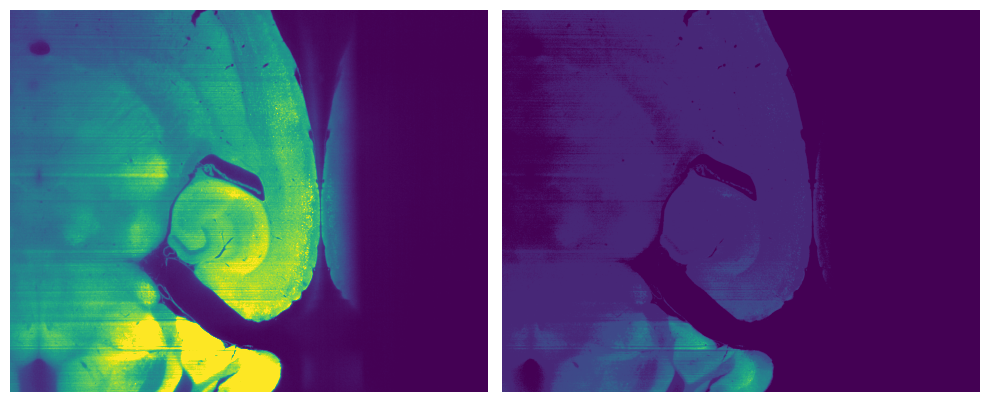

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin, vmax = np.percentile(tile, (10, 97))
# Display images
# plt.suptitle("flatfield")
ax1.imshow(tile, vmin=vmin, vmax=vmax)
ax1.axis('off')  # Turn off axis labels

vmin, vmax = np.percentile(corrected_image, (0.1, 99.9))
ax2.imshow(corrected_image_2)#, vmin=vmin, vmax=vmax)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()